In [1]:
import numpy as np
import math
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

pd.options.display.max_columns = 99
pd.options.display.max_rows = 99
path1='/Users/jinjuanshi/Documents/Statistics/253/Project/novel-corona-virus-2019-dataset 5_3/COVID19_open_line_list.csv'

origin=pd.read_csv(path1)

col_to_keep=['ID','age','sex','city','province','country','latitude','longitude',
             'geo_resolution','date_onset_symptoms','date_admission_hospital','date_confirmation','symptoms',
            'lives_in_Wuhan','travel_history_dates','travel_history_location','additional_information',
             'chronic_disease','location','admin3','admin2','admin1',
            ]

patient=origin[col_to_keep]
patient
pd.options.display.max_rows

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


99

In [2]:
patient.isna().sum()

ID                           953
age                        12777
sex                        12862
city                        3932
province                    1220
country                      978
latitude                     979
longitude                    979
geo_resolution               979
date_onset_symptoms        13380
date_admission_hospital    13396
date_confirmation           1037
symptoms                   13633
lives_in_Wuhan             13561
travel_history_dates       13623
travel_history_location    13368
additional_information     11714
chronic_disease            14113
location                   13102
admin3                     12967
admin2                      5058
admin1                      1249
dtype: int64

## Data wrangling

***Drop observation, fill na***
```
1,dropping some rows do not have ID at last ,which are all fill with na
2,filling country.isna() with China
```

In [3]:
#1
index1=patient.ID[patient.ID.isna()].index
patient.drop(index1,axis=0,inplace=True)
#2

patient.loc[patient.country[patient.country.isna()].index]
patient['country'].fillna('China',inplace=True)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [4]:
print(patient.shape)
print(patient.isna().sum())

(13173, 22)
ID                             0
age                        11825
sex                        11910
city                        2979
province                     267
country                        0
latitude                      26
longitude                     26
geo_resolution                26
date_onset_symptoms        12427
date_admission_hospital    12443
date_confirmation             84
symptoms                   12680
lives_in_Wuhan             12608
travel_history_dates       12670
travel_history_location    12415
additional_information     10761
chronic_disease            13160
location                   12149
admin3                     12014
admin2                      4105
admin1                       296
dtype: int64


***Uniform features***
```
1,uniform age
2,uniform sex
3,uniform date_onset_symptoms,date_admission_hospital,date_confirmation
4,uniform text:symptoms,travel_history_location,additional_information
```

In [5]:
##age
patient.loc[:,'age']=patient.age.astype(str)
def modify_age(x):
    if '-' in x:
        pos=x.find('-')
        x=(int(x[:pos])+int(x[pos+1:]))/2
    elif x in ['0.0833','0.25','0.5','0.58333']:
        x=1
    elif '.' in x:
        x=math.ceil(float(x))
    elif x=='nan':
        x=np.nan
    else:
        x=float(x)
    return x
patient.loc[:,'age']=patient['age'].apply(lambda x: modify_age(x))

#sex

def modify_sex(x):
    if x=='Female' or x=='female':
        x=0
    elif x=='Male' or x=='male':
        x=1
    return x
patient.loc[:,'sex'] = patient['sex'].apply(lambda x :modify_sex(x))

#date_onset_symptoms

def modify_date_onset_symptoms(x):
    if x=='-25.02.2020':
        x='25.02.2020'
    elif x=='01.31.2020':
        x='31.01.2020'
    elif x=='10.01.2020 - 22.01.2020':
        x='16.01.2020'
    elif x=='20.02.220':
        x='20.02.2020'
    elif x=='end of December 2019':
        x='31.12.2019'
    elif x=='04.04.2020':
        x='04.02.2020'
    elif x=='none':
        x=np.nan        
    return x

patient.loc[:,'date_onset_symptoms'] = patient['date_onset_symptoms'].apply(lambda x :modify_date_onset_symptoms(x))

#date_admission_hospital

def modify_date_admission_hospital(x):
    if x=='02.17.2020':
        x='17.02.2020'
    elif x=='18.01.2020 - 23.01.2020':
        x='20.01.2020'
    elif x=='9.01.2020':
        x='09.01.2020'
    return x

patient.loc[:,'date_admission_hospital'] = patient['date_admission_hospital'].apply(lambda x :modify_date_admission_hospital(x))

#date_confirmation
def modify_date_confirmation(x):
    if x== '25.02.2020-26.02.2020':
        x='26.02.2020'
    return x
patient.loc[:,'date_confirmation'] = patient['date_confirmation'].apply(lambda x :modify_date_confirmation(x))

#lives_in_Wuhan
def modify_lives_in_Wuhan(x):
    if x in ['Chinese','Xiantao City resident','Yes','lived in Wuhan for two months and then went back to Cangzhou', 
            'no, work in Wuhan','work in Wuhan','yes','1']:
        x=1
    
    elif x in ['No','business trip','live in Hangzhou','medical trip','no','thai national','tourism','0',
              'return from Wuhan','shanghai resident, travel history','study trip','travel','used to be']:
        x=0
    return x

patient.loc[:,'lives_in_Wuhan'] = patient['lives_in_Wuhan'].apply(lambda x :modify_lives_in_Wuhan(x))  

#symptoms
print(patient.symptoms.dtypes)
patient.loc[:,'symptoms']=patient.symptoms.astype(str)

def modify_symptoms(x):
    if x!=np.nan:
        x=x.lower()
        x=x.replace('(',',')
        x=x.replace('℃)','℃')
        x=x.replace('° c)','° c')
        x=x.replace('r 3','r,3')
        x=x.replace(';',',')

    return x
patient.loc[:,'symptoms'] = patient['symptoms'].apply(lambda x :modify_symptoms(x)).replace('nan',np.nan)

#travel_history_location
patient.loc[:,'travel_history_location']=patient.travel_history_location.astype(str)
def modify_travel_history_location(x):
    if x.startswith('#'):
        x='Hokkaido'
    return x  

patient.loc[:,'travel_history_location']=patient['travel_history_location'].apply(
    lambda x :modify_travel_history_location(x)).replace('nan',np.nan)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


object


***Transform date type***

In [6]:
#1
patient.loc[:,'date_onset_symptoms']=pd.to_datetime(patient['date_onset_symptoms'],dayfirst=True)

patient.loc[:,'date_admission_hospital']=pd.to_datetime(patient['date_admission_hospital'],dayfirst=True)

patient.loc[:,'date_confirmation']=pd.to_datetime(patient['date_confirmation'],dayfirst=True)



## Word Cloud

we can see fever,cough,fatigue,pneumonia,chills,sore throat,runny nose,headache,malaise are most common sympotom.

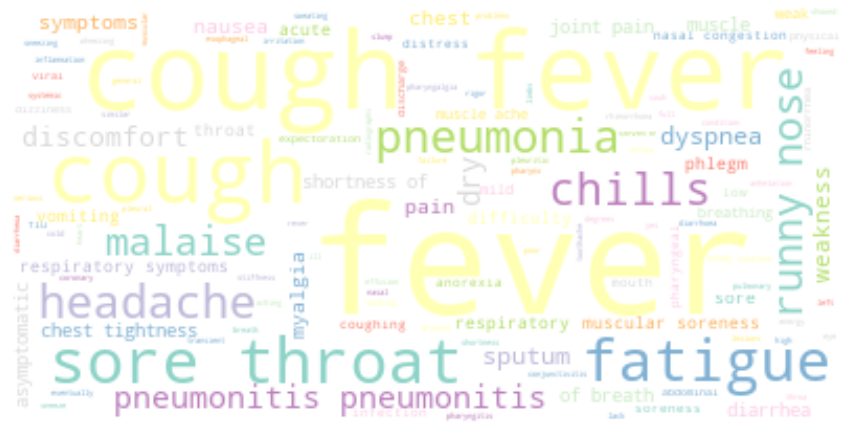

In [7]:

from wordcloud import WordCloud, ImageColorGenerator
from matplotlib import pyplot as plt
symptoms_after=patient.symptoms[~patient.symptoms.isna()]
text = " ".join(str(each) for each in symptoms_after)
wordcloud = WordCloud(max_words=200,colormap='Set3', background_color="white").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.savefig('word cloud of symptoms.png');

In [8]:
do_pca_col=['age','sex','city','province','country','symptoms','lives_in_Wuhan','travel_history_location',
            'additional_information','chronic_disease']
do_pca=patient.copy()[do_pca_col]

## Encode

In [9]:
#age
print([do_pca.age.min(),do_pca.age.max()])

def cat_age(x):     # 1-9:0,10-19:1.....
    for i in range(10):
        if x>=10*i and x<=10*i+9:
            x=i
    return x
do_pca.loc[:,'age']=do_pca['age'].apply(lambda x :cat_age(x))

#city,province,country

city_province_country = OneHotEncoder(handle_unknown='ignore')
X=do_pca[['city','province','country']].fillna('unknown')

y = city_province_country.fit_transform(X)
print(y.shape)
#df=pd.DataFrame(y.toarray(),columns=city_province_country.get_feature_names())
#do_pca=pd.concat([do_pca,df],axis=1).drop(['city','province','country'],axis=1)

matrix=np.concatenate((do_pca[['age','sex']].to_numpy(),y.toarray()),axis=1)
print(matrix.shape)



[1.0, 96.0]
(13173, 1009)
(13173, 1011)


In [10]:
#symptoms
corpus1=do_pca.symptoms.fillna('unknown')
vectorizer1=TfidfVectorizer()
#vectorizer1=CountVectorizer()
y= vectorizer1.fit_transform(corpus1)
print(vectorizer1.get_feature_names())
matrix=np.concatenate((matrix,y.toarray(),do_pca.lives_in_Wuhan.to_numpy().reshape(-1,1)),axis=1)
matrix.shape


#additional_information
corpus2=do_pca.additional_information.fillna('unknown')
vectorizer2=TfidfVectorizer()
#vectorizer2=CountVectorizer()
y= vectorizer2.fit_transform(corpus2)
# print(vectorizer2.get_feature_names())
matrix=np.concatenate((matrix,y.toarray()),axis=1)
matrix.shape

#chronic_disease
corpus3=do_pca.chronic_disease.fillna('unknown')
vectorizer=TfidfVectorizer()
#vectorizer=CountVectorizer()
y= vectorizer.fit_transform(corpus3)
# print(vectorizer.get_feature_names())
matrix=np.concatenate((matrix,y.toarray()),axis=1)
matrix.shape


['37', '38', '39', '40', 'abdominal', 'ache', 'aches', 'aching', 'acute', 'and', 'anhelation', 'anorexia', 'asymptomatic', 'body', 'breath', 'breathing', 'chest', 'chills', 'cold', 'condition', 'congestion', 'conjunctivitis', 'coronary', 'cough', 'coughing', 'couh', 'degrees', 'diarrhea', 'diarrheoa', 'diarrhoea', 'difficulty', 'discharge', 'discomfort', 'distress', 'dizziness', 'dry', 'dryness', 'dyspnea', 'effusion', 'energy', 'esophageal', 'eventually', 'expectoration', 'eye', 'failure', 'fatigue', 'feeling', 'fever', 'flu', 'full', 'general', 'headache', 'heart', 'high', 'ill', 'infection', 'inflammation', 'irritation', 'joint', 'lack', 'left', 'lesions', 'like', 'limbs', 'low', 'malaise', 'mild', 'mouth', 'muscle', 'muscles', 'muscular', 'myalgia', 'myalgias', 'nasal', 'nausea', 'no', 'nose', 'of', 'on', 'other', 'pain', 'pharyngalgia', 'pharyngeal', 'pharyngitis', 'pharynx', 'phlegm', 'physical', 'pleural', 'pleuritic', 'pneumonia', 'pneumonitis', 'poor', 'problems', 'pulmonary',

(13173, 2537)

## PCA

In [11]:
X =np.nan_to_num(matrix,nan=-1)
print(X.shape)
pca = PCA(0.8)
pca.fit_transform(X.T)

pca.components_.shape

(13173, 2537)


(4, 13173)

## Plot
2D plot on labled information

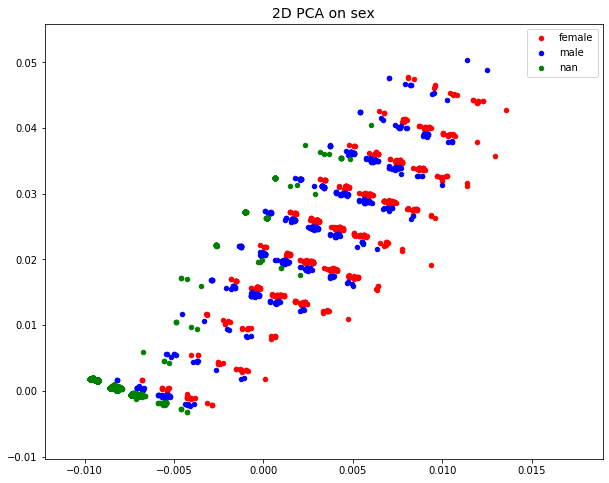

In [12]:
#2Dplot for sex
f_index=np.argwhere(X[:,1]==1.0)
m_index=np.argwhere(X[:,1]==0.0)
na_index=np.argwhere(X[:,1]==-1)



fig=plt.figure(figsize=(10,8))
plt.scatter(pca.components_[0,:][f_index],pca.components_[1,:][f_index],c='red',s=20,label='female')
plt.scatter(pca.components_[0,:][m_index],pca.components_[1,:][m_index],c='blue',s=20,label='male')
plt.scatter(pca.components_[0,:][na_index],pca.components_[1,:][na_index],c='green',s=20,label='nan')
plt.title('2D PCA on sex',fontsize=14)
plt.legend()
plt.savefig('2D PCA on sex.png');

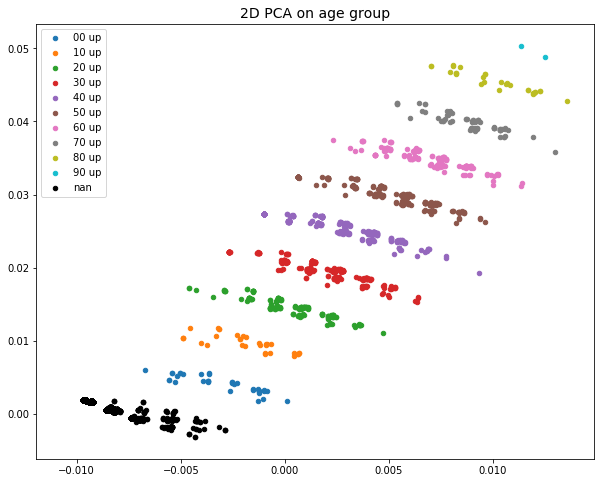

In [13]:
#2D plot for age
fig=plt.figure(figsize=(10,8))
for i in range(10):
    age_index=(X[:,0]==i)
    plt.scatter(pca.components_[0,:][age_index],pca.components_[1,:][age_index],
                s=20,label=str(i)+'0 up')
age_index=(X[:,0]==-1)
plt.scatter(pca.components_[0,:][age_index],pca.components_[1,:][age_index],
                s=20,label='nan',c='black')    
plt.title('2D PCA on age group',fontsize=14)
plt.legend()
plt.savefig('2D PCA on age group.png');

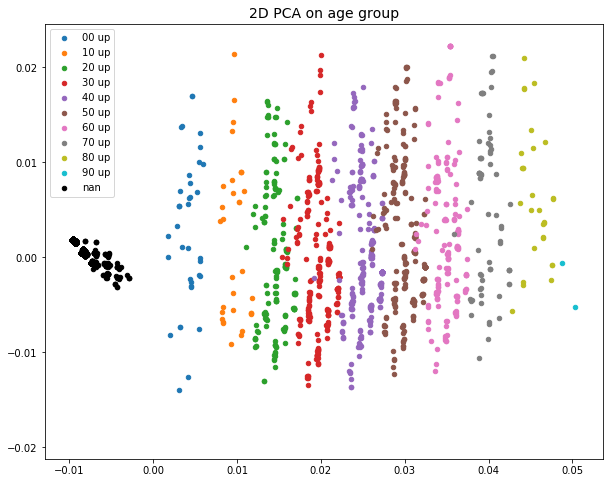

In [14]:
#2D plot for age
fig=plt.figure(figsize=(10,8))
for i in range(10):
    age_index=(X[:,0]==i)
    plt.scatter(pca.components_[1,:][age_index],pca.components_[2,:][age_index],
                s=20,label=str(i)+'0 up')
age_index=(X[:,0]==-1)
plt.scatter(pca.components_[0,:][age_index],pca.components_[1,:][age_index],
                s=20,label='nan',c='black')    
plt.title('2D PCA on age group',fontsize=14)
plt.legend()
plt.savefig('2D PCA on age group.png');

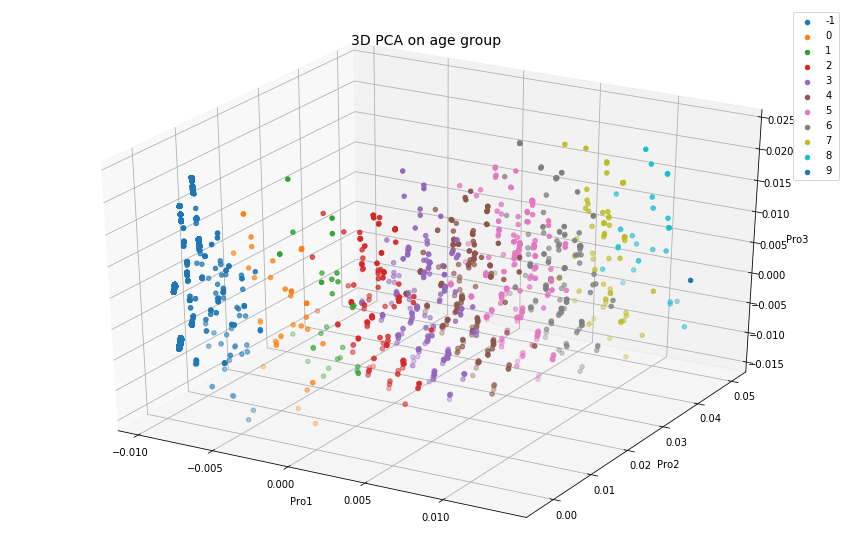

In [15]:
#3Dplot for age
from mpl_toolkits import mplot3d


fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

for i in range(-1,10):
    age_index=(X[:,0]==i)
    ax.scatter(pca.components_[0,:][age_index],pca.components_[1,:][age_index],pca.components_[2,:][age_index]
                ,label=i)
       

ax.set_xlabel('Pro1')
ax.set_ylabel('Pro2')
ax.set_zlabel('Pro3')
ax.set_title('3D PCA on age group',fontsize=14)
ax.legend();


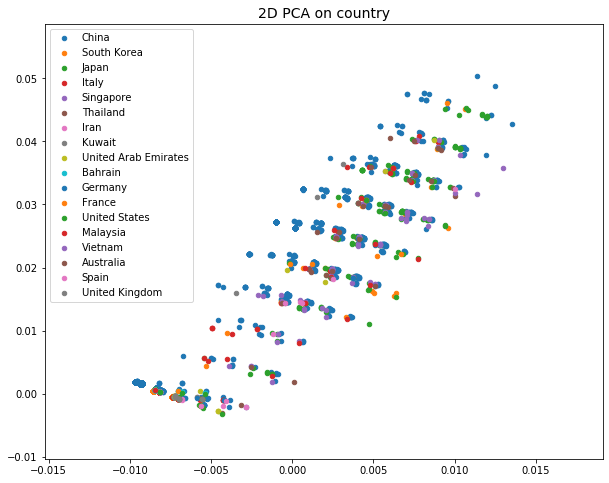

In [16]:
#2D plot for country
fig=plt.figure(figsize=(10,8))
con=(patient.groupby('country').count().sort_values('ID',ascending=False).index)[:18]
for i in range(len(con)):
    con_index=(patient.country==con[i]).to_numpy()
    plt.scatter(pca.components_[0,:][con_index],pca.components_[1,:][con_index],s=20,label=con[i])
plt.title('2D PCA on country',fontsize=14)
plt.legend()
plt.savefig('2D PCA on country.png');

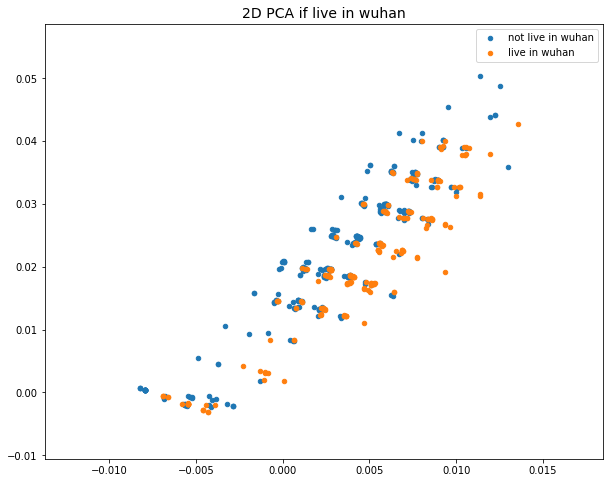

In [17]:
##2D plot for if live in wuhan

fig=plt.figure(figsize=(10,8))
live0_index=(patient['lives_in_Wuhan']==0).to_numpy()
live1_index=(patient['lives_in_Wuhan']==1).to_numpy()
plt.scatter(pca.components_[0,:][live0_index],pca.components_[1,:][live0_index],s=20,label='not live in wuhan')
plt.scatter(pca.components_[0,:][live1_index],pca.components_[1,:][live1_index],s=20,label='live in wuhan')
plt.title('2D PCA if live in wuhan',fontsize=14)
plt.legend()
plt.savefig('2D PCA if live in wuhan');

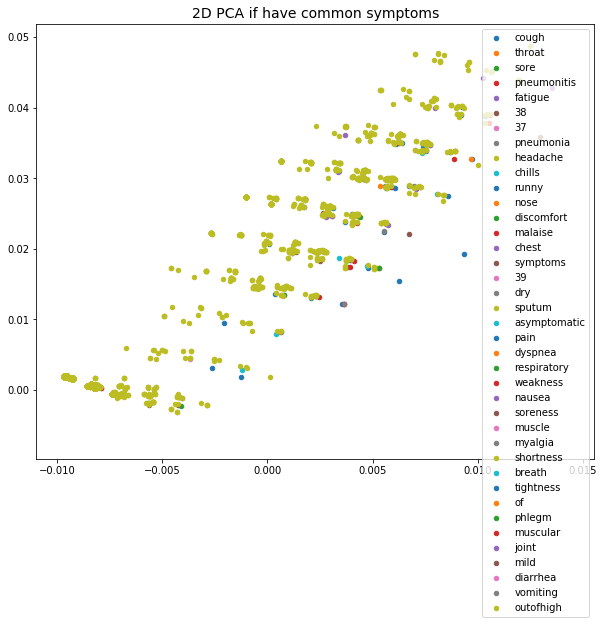

In [18]:
##2D plot symptoms
word=vectorizer1.get_feature_names()
freq_word=vectorizer1.fit_transform(corpus1).toarray().sum(axis=0)
index_word=freq_word.argsort()[::-1].tolist()
high_freq=[word[ind] for ind in index_word][1:40]#extractg 40 frequent words
high_freq

fig=plt.figure(figsize=(10,8))

patient_symptom = []
for i, row in patient.iterrows():
    symptom = 'outofhigh'
    for word in high_freq:
        if word in str(row['symptoms']):
            symptom = word
            break
    patient_symptom.append(symptom)

high_freq.append('outofhigh')
patient_symptom = pd.DataFrame(patient_symptom, columns=['symptom'])

for i in range(1,len(high_freq)):
    sym_index=(patient_symptom.symptom==high_freq[i]).to_numpy()
    plt.scatter(pca.components_[0,:][sym_index],pca.components_[1,:][sym_index],s=20,label=high_freq[i])

plt.title('2D PCA if have common symptoms',fontsize=14)    
plt.legend()
plt.savefig('2D PCA if have common symptoms.png');



In [19]:
path2='/Users/jinjuanshi/Documents/Statistics/253/Project/novel-corona-virus-2019-dataset 5_3/time_series_covid_19_confirmed_US.csv'
path3='/Users/jinjuanshi/Documents/Statistics/253/Project/novel-corona-virus-2019-dataset 5_3/time_series_covid_19_deaths_US.csv'

confirmed=pd.read_csv(path2)
deaths=pd.read_csv(path3)



## Cases in US with Time

In [20]:
# US state code to name mapping
state_map_dict = {'AL': 'Alabama',
 'AK': 'Alaska',
 'AS': 'American Samoa',
 'AZ': 'Arizona',
 'AR': 'Arkansas',
 'CA': 'California',
 'CO': 'Colorado',
 'CT': 'Connecticut',
 'DE': 'Delaware',
 'DC': 'District of Columbia',
 'D.C.': 'District of Columbia',
 'FM': 'Federated States of Micronesia',
 'FL': 'Florida',
 'GA': 'Georgia',
 'GU': 'Guam',
 'HI': 'Hawaii',
 'ID': 'Idaho',
 'IL': 'Illinois',
 'IN': 'Indiana',
 'IA': 'Iowa',
 'KS': 'Kansas',
 'KY': 'Kentucky',
 'LA': 'Louisiana',
 'ME': 'Maine',
 'MH': 'Marshall Islands',
 'MD': 'Maryland',
 'MA': 'Massachusetts',
 'MI': 'Michigan',
 'MN': 'Minnesota',
 'MS': 'Mississippi',
 'MO': 'Missouri',
 'MT': 'Montana',
 'NE': 'Nebraska',
 'NV': 'Nevada',
 'NH': 'New Hampshire',
 'NJ': 'New Jersey',
 'NM': 'New Mexico',
 'NY': 'New York',
 'NC': 'North Carolina',
 'ND': 'North Dakota',
 'MP': 'Northern Mariana Islands',
 'OH': 'Ohio',
 'OK': 'Oklahoma',
 'OR': 'Oregon',
 'PW': 'Palau',
 'PA': 'Pennsylvania',
 'PR': 'Puerto Rico',
 'RI': 'Rhode Island',
 'SC': 'South Carolina',
 'SD': 'South Dakota',
 'TN': 'Tennessee',
 'TX': 'Texas',
 'UT': 'Utah',
 'VT': 'Vermont',
 'VI': 'Virgin Islands',
 'VA': 'Virginia',
 'WA': 'Washington',
 'WV': 'West Virginia',
 'WI': 'Wisconsin',
 'WY': 'Wyoming'}

state_code_dict = {v:k for k, v in state_map_dict.items()}

    
def get_state_codes(x):
    try:
        return state_code_dict[x]
    except:
        return "Others"

confirmed["Province_State"] = confirmed["Province_State"].apply(lambda x: get_state_codes(x))


In [21]:
#USA map with time series
import plotly.offline as py
import plotly.express as px


py.init_notebook_mode(connected=True)

df=pd.concat([confirmed['Province_State'],confirmed.iloc[:,11:]],axis=1)
df
confirmed_time=df.melt('Province_State',var_name='Time', value_name='Value')
confirmed_time
confirmed_time=confirmed_time.groupby(['Time','Province_State']).sum()
confirmed_time=confirmed_time.reset_index()
confirmed_time['Time'] = pd.to_datetime(confirmed_time['Time'])
confirmed_time['Time'] = confirmed_time['Time'].dt.strftime('%m/%d/%Y')

fig = px.choropleth(locations=confirmed_time['Province_State'], locationmode='USA-states', 
                     color=confirmed_time['Value'],
                     scope='usa',
                     animation_frame=confirmed_time['Time'],width=800, height=600,
                     color_continuous_scale='Reds',
                     range_color=[0,200000],
                     title='Cases in United States with Time')

fig.update(layout_coloraxis_showscale=True)
py.offline.iplot(fig,filename='/Users/jinjuanshi/Documents/Statistics/253/Case with time.html');


## USA map show deaths case

In [22]:
with_deaths=deaths[deaths['5/2/20']>0]
import folium
usa_map = folium.Map(location=[37.0902,-95.7129], zoom_start=5,tiles='Stamen Toner')

for lat, lon,county,case in zip(with_deaths['Lat'], with_deaths['Long_'],with_deaths['Admin2'],with_deaths['5/2/20']):
    folium.CircleMarker([lat, lon],
                        radius=case*0.005,
                        color="#007849",
                        popup =('County: ' + str(county) + '<br>'
                              'Case No:'+str(case)+'<br>'),
                        fill_color='b',
                        fill_opacity=0.3 ).add_to(usa_map)
usa_map.save('Deaths distribution.html')

usa_map


## Kmeans clustering

(1348, 4)
640
708


,ID,age,sex,city,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,date_admission_hospital,date_confirmation,symptoms,lives_in_Wuhan,travel_history_dates,travel_history_location,additional_information,chronic_disease,location,admin3,admin2,admin1
4,5.0,50.0,0.0,"Feidong County, Hefei City",Anhui,China,32.00123,117.5681,admin3,2020-01-10,2020-01-21,2020-01-23,NaN,0.0,07.01.2020,Wuhan,"06.01.2020 went to Wuhan, 07.01.2020 returned ...",NaN,NaN,Feidong County,Hefei City,Anhui
38,39.0,65.0,1.0,NaN,Beijing,China,40.18535,116.4151,admin1,2020-01-22,2020-01-22,2020-01-23,NaN,NaN,NaN,Hubei,NaN,NaN,NaN,NaN,NaN,Beijing
79,80.0,70.0,1.0,Fuzhou City,Fujian,China,26.05196,119.1789,admin2,NaT,2020-01-20,2020-01-22,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Fuzhou City,Fujian
80,81.0,43.0,0.0,Ningde City,Fujian,China,26.97674,119.4745,admin2,2020-01-21,2020-01-21,2020-01-23,NaN,NaN,21.01.2020,Wuhan,doing business in Wuhan; Xiapu County Hospital,NaN,NaN,NaN,Ningde City,Fujian
98,99.0,66.0,1.0,Shenzhen City,Guangdong,China,22.65389,114.1291,admin2,2020-01-04,2020-01-10,2020-01-19,"cough, fatigue, fever, weakness",0.0,29.12.2019 - 04.01.2020,Wuhan,"Among the 53 cases diagnosed in our province, ...",NaN,NaN,NaN,Shenzhen City,Guangdong
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13166,13472.0,64.5,0.0,Sapporo City,Hokkaido,Japan,NaN,NaN,NaN,2020-02-20,NaT,2020-02-28,fever and cough,NaN,NaN,Hokkaido,NaN,NaN,NaN,NaN,NaN,NaN
13167,13473.0,64.5,1.0,Sapporo City,Hokkaido,Japan,NaN,NaN,NaN,2020-02-18,2020-02-28,2020-02-28,fever,NaN,NaN,Hokkaido,NaN,NaN,NaN,NaN,NaN,NaN
13168,13474.0,54.5,1.0,NaN,Ishikawa,Japan,NaN,NaN,NaN,NaT,NaT,2020-02-28,NaN,NaN,NaN,asymptomatic carrier,NaN,NaN,NaN,NaN,NaN,NaN
13169,13475.0,64.5,1.0,Nagoya City,Aichi Prefecture,Japan,NaN,NaN,NaN,2020-02-27,NaT,2020-02-28,"fever ,38 ° c",NaN,NaN,Hokkaido,NaN,NaN,NaN,NaN,NaN,NaN


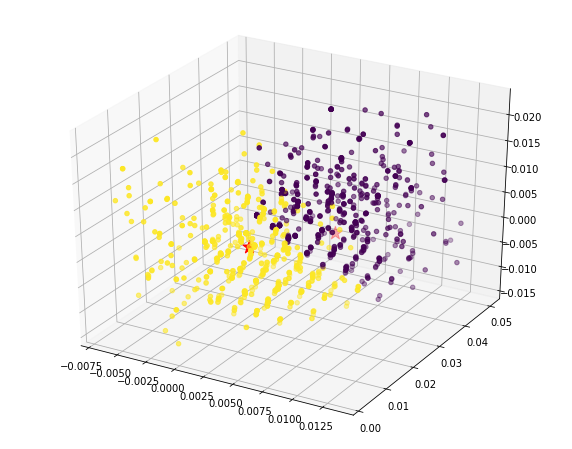

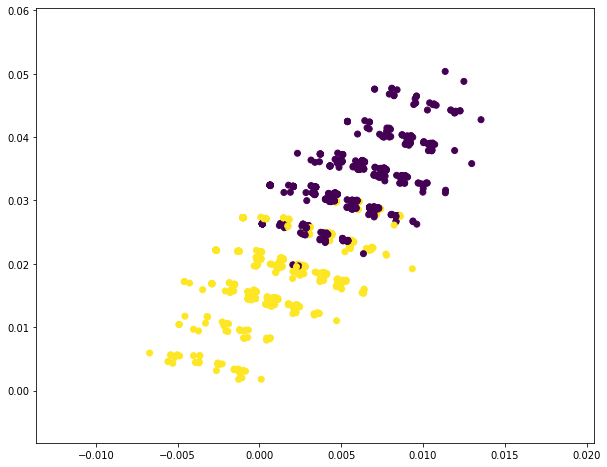

In [46]:
clus=pca.components_.T[~patient.age.isna()]#remove age is na and do clustering
print(clus.shape)
from sklearn.cluster import KMeans 
kmeans = KMeans(n_clusters =2, init ='k-means++')
kmeans.fit(clus)
centers = kmeans.cluster_centers_
labels = kmeans.predict(clus)
labels


from mpl_toolkits import mplot3d

#3D plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(clus[:, 0], clus[:, 1], clus[:,2], c=labels)
ax.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='*');


#2D plot
fig = plt.figure(figsize=(10,8))
plt.scatter(clus[:,0],clus[:,1],c=labels);

#calculate number of clusters
for i in range(2):
    print(np.sum(labels==i))
#show list of clusters
clus_raw=patient[~patient.age.isna()]

idx0=np.asarray(np.where(labels==0))

idx0=idx0.flatten().tolist()
clus_raw.iloc[idx0]



In [48]:
for i in range(2):
    print(np.sum(labels==i))

clus_raw=patient[~patient.age.isna()]

idx0=np.asarray(np.where(labels==0))

idx0=idx0.flatten().tolist()
clus_raw.iloc[idx0]



idx1=np.asarray(np.where(labels==1))

idx1=idx1.flatten().tolist()
clus_raw.iloc[idx1]

640
708


,ID,age,sex,city,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,date_admission_hospital,date_confirmation,symptoms,lives_in_Wuhan,travel_history_dates,travel_history_location,additional_information,chronic_disease,location,admin3,admin2,admin1
0,1.0,30.0,1.0,"Chaohu City, Hefei City",Anhui,China,31.646960,117.716600,admin3,2020-01-18,2020-01-20,2020-01-22,NaN,1.0,17.01.2020,Wuhan,NaN,NaN,NaN,Chaohu City,Hefei City,Anhui
1,2.0,47.0,1.0,"Baohe District, Hefei City",Anhui,China,31.778630,117.331900,admin3,2020-01-10,2020-01-21,2020-01-23,NaN,0.0,10.01.2020,"Luzhou Hunan, via Wuhan",NaN,NaN,NaN,Baohe District,Hefei City,Anhui
2,3.0,49.0,1.0,"High-Tech Zone, Hefei City",Anhui,China,31.828313,117.224844,point,2020-01-15,2020-01-20,2020-01-23,NaN,0.0,10.01.2020,"Yinzhou Hunan, via Wuhan",NaN,NaN,High-Tech Zone,Shushan District,Hefei City,Anhui
3,4.0,47.0,0.0,"High-Tech Zone, Hefei City",Anhui,China,31.828313,117.224844,point,2020-01-17,2020-01-20,2020-01-23,NaN,0.0,NaN,NaN,contacted with confirmed case,NaN,High-Tech Zone,Shushan District,Hefei City,Anhui
6,7.0,42.0,0.0,Fuyang City,Anhui,China,32.918800,115.703600,admin2,2020-01-21,2020-01-21,2020-01-22,fever,0.0,19.01.2020,Wuhan,transportation drivers often travel between Wu...,NaN,NaN,NaN,Fuyang City,Anhui
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13145,13451.0,38.0,0.0,Timisoara,NaN,Romania,45.759722,21.230000,point,2020-02-25,2020-02-27,2020-02-28,NaN,NaN,NaN,"Bergamo, Italy",NaN,NaN,NaN,NaN,NaN,NaN
13149,13455.0,39.0,0.0,Siauliai,NaN,Lithuania,55.933333,23.316667,point,NaT,2020-02-27,2020-02-28,mild,NaN,24.02.2020,"Verona, Italy",NaN,NaN,NaN,NaN,NaN,NaN
13154,13460.0,24.5,1.0,Sagamihara City,Kanagawa,Japan,NaN,NaN,NaN,2020-02-23,NaT,2020-02-27,fever,NaN,NaN,Hokkaido,NaN,NaN,NaN,NaN,NaN,NaN
13157,13463.0,5.0,1.0,Chitose,Hokkaido,Japan,NaN,NaN,NaN,2020-02-18,NaT,2020-02-28,"fever,39.0 ℃",NaN,NaN,Hokkaido,NaN,NaN,NaN,NaN,NaN,NaN
